In [1]:
import pandas as pd
import seaborn as sns
import sqlite3

from datetime import datetime
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from pokemon_showdown_replay_tools.analysis import parse_replay
from pokemon_showdown_replay_tools.sqlite import (
    create_appearances_table,
    get_pair_marginal_win_rates,
    get_pair_marginal_win_rates_conditional,
)

sns.set_style('darkgrid')

In [2]:
%%time
con = sqlite3.connect('../replays.regh.db')
try:
    create_appearances_table(con)
except sqlite3.OperationalError:
    print("DB already exists")

cur = con.cursor()
cur.execute("""
    CREATE INDEX IF NOT EXISTS rating_idx ON replays(rating)
""")
cur.execute("""
    CREATE INDEX IF NOT EXISTS uploadtime_idx ON replays(uploadtime)
""")

where = 'WHERE rating > 1200 AND 1729462785 < uploadtime AND uploadtime <= 1730067553'
result = get_pair_marginal_win_rates_conditional(
    con,
    where,
    explain=True
)
for r in result: print(r)
df = pd.DataFrame(
    data=get_pair_marginal_win_rates_conditional(con, where),
    columns=["p1", "p2", "players", "appearances", "wins", "win_rate"],
)

con.close()

df

DB already exists
(2, 0, 0, 'CO-ROUTINE marginal')
(4, 2, 0, 'CO-ROUTINE pairs')
(12, 4, 109, 'SEARCH appearances USING INDEX sqlite_autoindex_appearances_1 (id=?)')
(16, 4, 0, 'LIST SUBQUERY 1')
(20, 16, 162, 'SEARCH replays USING INDEX uploadtime_idx (uploadtime>? AND uploadtime<?)')
(32, 16, 0, 'CREATE BLOOM FILTER')
(43, 4, 0, 'REUSE LIST SUBQUERY 1')
(50, 4, 47, 'SEARCH appearances USING COVERING INDEX sqlite_autoindex_appearances_1 (id=? AND player=? AND pokemon>?)')
(57, 4, 0, 'REUSE LIST SUBQUERY 1')
(64, 4, 0, 'USE TEMP B-TREE FOR GROUP BY')
(115, 2, 82, 'SCAN pairs')
(118, 2, 0, 'USE TEMP B-TREE FOR GROUP BY')
(165, 0, 82, 'SCAN marginal')
(180, 0, 0, 'USE TEMP B-TREE FOR ORDER BY')
CPU times: total: 875 ms
Wall time: 944 ms


,p1,p2,players,appearances,wins,win_rate
0,Archaludon,Pelipper,1083,2928,1508,0.515027
1,Indeedee,Sneasler,595,1945,1005,0.516710
2,Rillaboom,Sneasler,773,1829,850,0.464735
3,Kingambit,Sneasler,660,1648,815,0.494539
4,Indeedee-F,Torkoal,482,1355,674,0.497417
...,...,...,...,...,...,...
15762,Weezing,Wyrdeer,1,1,0,0.000000
15763,Weezing-Galar,Wyrdeer,1,1,0,0.000000
15764,Whimsicott,Wyrdeer,1,1,1,1.000000
15765,Whimsicott,Yanma,1,1,1,1.000000


In [3]:
%%time
con = sqlite3.connect('../replays.regh.db')

df = pd.read_sql("SELECT id, uploadtime FROM replays ORDER BY uploadtime ASC", con, 
                 columns=['id', 'uploadtime']
                )
df.uploadtime = df.uploadtime.astype(int)
df = df.set_index('id')

min_time = df.uploadtime.min()
max_time = df.uploadtime.max()
one_week = 60 * 60 * 24 * 7
N = ((max_time - min_time) + one_week - 1) // one_week
bins = [min_time + i * one_week + (-1 if i == 0 else 0) for i in range(N+1)]
df['week'] = pd.cut(df.uploadtime, bins=bins)
df.uploadtime = df.uploadtime.apply(datetime.fromtimestamp)

dfs = []
for i, (label, grouped_df) in enumerate(tqdm(df.groupby(by="week"))):
    if i == 16: break
    week_start, week_end = label.left, label.right

    rating_cutoff = 1300
    where = f"WHERE uploadtime > {week_start} AND uploadtime <= {week_end} "
    marginal_df = pd.DataFrame(
        data=get_pair_marginal_win_rates_conditional(con, where),
        columns=["p1", "p2", "players", "appearances", "wins", "win_rate"],
    )
    marginal_df['week'] = i+1
    marginal_df['rating'] = f"1000 to {rating_cutoff}"
    dfs.append(marginal_df)

con.close()

all_ratings_df = pd.concat(dfs, axis=0, ignore_index=True)
all_ratings_df

<timed exec>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: total: 21.9 s
Wall time: 35.1 s


,p1,p2,players,appearances,wins,win_rate,week,rating
0,Archaludon,Pelipper,1624,4422,2233,0.504975,1,1000 to 1300
1,Palafin,Palafin-Hero,1765,3398,1454,0.427899,1,1000 to 1300
2,Incineroar,Rillaboom,1354,2279,1032,0.452830,1,1000 to 1300
3,Gholdengo,Incineroar,1100,2129,1053,0.494598,1,1000 to 1300
4,Gholdengo,Rillaboom,930,1947,965,0.495634,1,1000 to 1300
...,...,...,...,...,...,...,...,...
354212,Weezing,Zoroark,1,1,0,0.000000,16,1000 to 1300
354213,Whimsicott,Zoroark,1,1,0,0.000000,16,1000 to 1300
354214,Whimsicott,Zoroark-Hisui,1,1,0,0.000000,16,1000 to 1300
354215,Wiglett,Wooper-Paldea,1,1,0,0.000000,16,1000 to 1300


,appearances
pair,
"Archaludon, Pelipper",77015
"Basculegion, Pelipper",30700
"Amoonguss, Primarina",5132
"Annihilape, Grimmsnarl",5020
"Indeedee, Sneasler",14198
"Dondozo, Garganacl",657


CPU times: total: 5.14 s
Wall time: 5.97 s


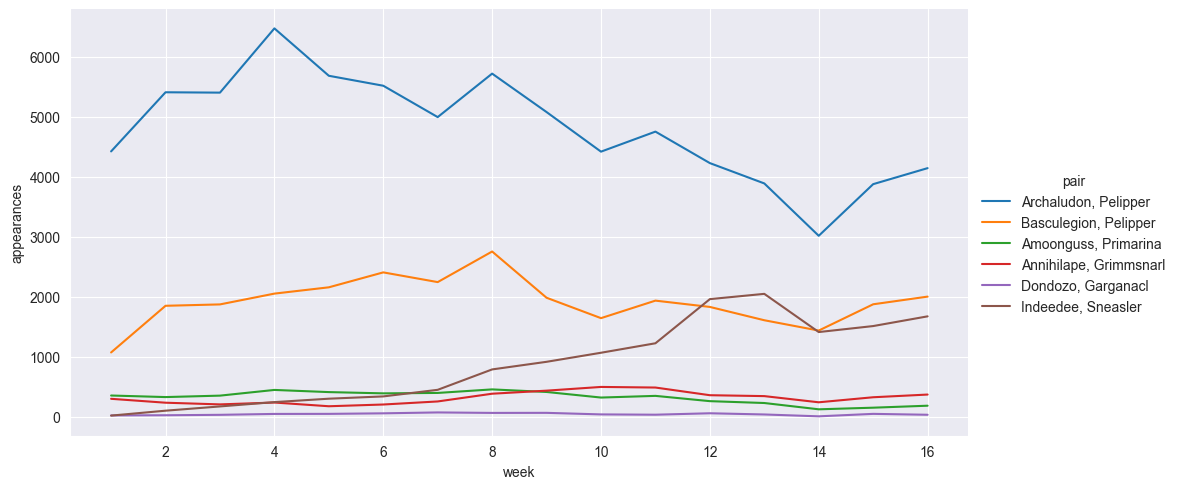

In [4]:
%%time
if 'pair' not in all_ratings_df: all_ratings_df['pair'] = all_ratings_df.apply(lambda row: row.p1 + ", " + row.p2, axis=1)
most_common_pairs = all_ratings_df.groupby(by='pair').agg({"appearances": "sum"}).sort_values(by="appearances", ascending=False)
N = 2
display_list = list(most_common_pairs[:N].index)
APPEARANCES_CUTOFF = 5000
display_list += list(most_common_pairs[most_common_pairs.appearances > APPEARANCES_CUTOFF][-N:].index)
display_list += [
    "Indeedee, Sneasler",
    "Dondozo, Garganacl",
]
display(most_common_pairs.loc[display_list])
facetgrid = sns.relplot(
    data=all_ratings_df[all_ratings_df.pair.isin(display_list)],
    x="week",
    y="appearances",
    kind="line",
    hue="pair",
    aspect=2,
);

,appearances
pair,
"Archaludon, Pelipper",77015
"Basculegion, Pelipper",30700
"Amoonguss, Primarina",5132
"Annihilape, Grimmsnarl",5020
"Indeedee, Sneasler",14198
"Dondozo, Garganacl",657


CPU times: total: 859 ms
Wall time: 979 ms


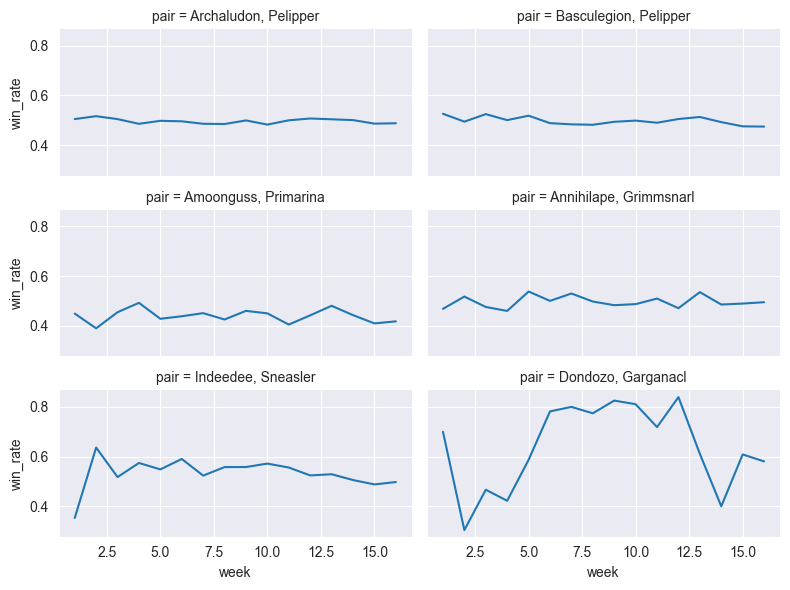

In [15]:
%%time
if 'pair' not in all_ratings_df: all_ratings_df['pair'] = all_ratings_df.apply(lambda row: row.p1 + ", " + row.p2, axis=1)
most_common_pairs = all_ratings_df.groupby(by='pair').agg({"appearances": "sum"}).sort_values(by="appearances", ascending=False)
N = 2
display_list = list(most_common_pairs[:N].index)
APPEARANCES_CUTOFF = 5000
display_list += list(most_common_pairs[most_common_pairs.appearances > APPEARANCES_CUTOFF][-N:].index)
display_list += [
    "Indeedee, Sneasler",
    "Dondozo, Garganacl",
]
display(most_common_pairs.loc[display_list])
facetgrid = sns.relplot(
    data=all_ratings_df[all_ratings_df.pair.isin(display_list)],
    x="week",
    y="win_rate",
    kind="line",
    col="pair",
    col_wrap=2,
    col_order = display_list,
    aspect=2,
    height=2,
);

In [9]:
%%time
con = sqlite3.connect('../replays.regh.db')

df = pd.read_sql("SELECT id, uploadtime FROM replays ORDER BY uploadtime ASC", con, 
                 columns=['id', 'uploadtime']
                )
df.uploadtime = df.uploadtime.astype(int)
df = df.set_index('id')

min_time = df.uploadtime.min()
max_time = df.uploadtime.max()
one_week = 60 * 60 * 24 * 7
N = ((max_time - min_time) + one_week - 1) // one_week
bins = [min_time + i * one_week + (-1 if i == 0 else 0) for i in range(N+1)]
df['week'] = pd.cut(df.uploadtime, bins=bins)
df.uploadtime = df.uploadtime.apply(datetime.fromtimestamp)

dfs = []
for i, (label, grouped_df) in enumerate(tqdm(df.groupby(by="week"))):
    if i == 16: break
    week_start, week_end = label.left, label.right

    rating_cutoffs = [1000, 1300, None]
    for rating_start, rating_end in zip(rating_cutoffs[:-1], rating_cutoffs[1:]):
        rating_cutoff = 1300
        if rating_end is not None:
            where = f"WHERE uploadtime > {week_start} AND uploadtime <= {week_end} AND ({rating_start} <= rating AND rating < {rating_end})"
        else:
            where = f"WHERE uploadtime > {week_start} AND uploadtime <= {week_end} AND ({rating_start} <= rating)"
        marginal_df = pd.DataFrame(
            data=get_pair_marginal_win_rates_conditional(con, where),
            columns=["p1", "p2", "players", "appearances", "wins", "win_rate"],
        )
        marginal_df['week'] = i+1
        if rating_end is not None:
            marginal_df['rating'] = f"{rating_start} to {rating_end}"
        else:
            marginal_df['rating'] = f"{rating_start}+"
        dfs.append(marginal_df)

con.close()

by_ratings_df = pd.concat(dfs, axis=0, ignore_index=True)
by_ratings_df

<timed exec>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: total: 29 s
Wall time: 32.5 s


,p1,p2,players,appearances,wins,win_rate,week,rating
0,Archaludon,Pelipper,1318,2551,1301,0.509996,1,1000 to 1300
1,Palafin,Palafin-Hero,1419,2222,940,0.423042,1,1000 to 1300
2,Incineroar,Rillaboom,1070,1496,673,0.449866,1,1000 to 1300
3,Gholdengo,Incineroar,851,1267,615,0.485399,1,1000 to 1300
4,Armarouge,Indeedee-F,581,1153,581,0.503903,1,1000 to 1300
...,...,...,...,...,...,...,...,...
508299,Volcarona,Yanma,1,1,1,1.000000,16,1300+
508300,Weavile,Zoroark-Hisui,1,1,0,0.000000,16,1300+
508301,Weezing,Whimsicott,1,1,1,1.000000,16,1300+
508302,Weezing-Galar,Yanmega,1,1,0,0.000000,16,1300+


,appearances
pair,
"Archaludon, Pelipper",77015
"Basculegion, Pelipper",30700
"Amoonguss, Primarina",5132
"Annihilape, Grimmsnarl",5020
"Indeedee, Sneasler",14198
"Dondozo, Garganacl",657


CPU times: total: 7.48 s
Wall time: 8.65 s


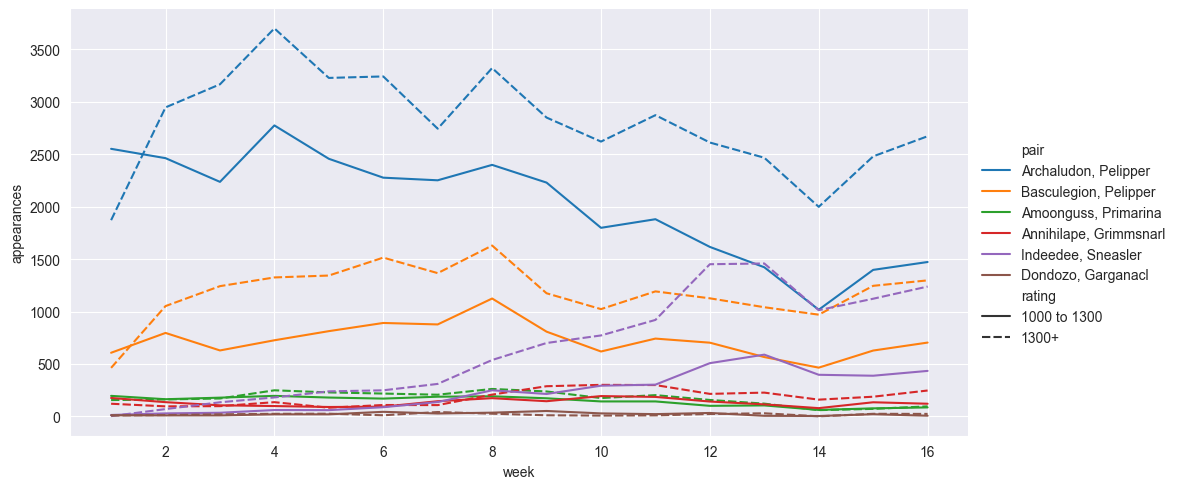

In [10]:
%%time
if 'pair' not in by_ratings_df: by_ratings_df['pair'] = by_ratings_df.apply(lambda row: row.p1 + ", " + row.p2, axis=1)
most_common_pairs = by_ratings_df.groupby(by='pair').agg({"appearances": "sum"}).sort_values(by="appearances", ascending=False)
N = 2
display_list = list(most_common_pairs[:N].index)
APPEARANCES_CUTOFF = 5000
display_list += list(most_common_pairs[most_common_pairs.appearances > APPEARANCES_CUTOFF][-N:].index)
display_list += [
    "Indeedee, Sneasler",
    "Dondozo, Garganacl",
]
display(most_common_pairs.loc[display_list])
facetgrid = sns.relplot(
    data=by_ratings_df[by_ratings_df.pair.isin(display_list)],
    x="week",
    y="appearances",
    kind="line",
    hue='pair',
    style="rating",
    # col_wrap=2,
    # col_order=display_list,
    aspect=2,
);

,appearances
pair,
"Archaludon, Pelipper",77015
"Basculegion, Pelipper",30700
"Amoonguss, Primarina",5132
"Annihilape, Grimmsnarl",5020
"Indeedee, Sneasler",14198
"Dondozo, Garganacl",657


CPU times: total: 1.31 s
Wall time: 1.42 s


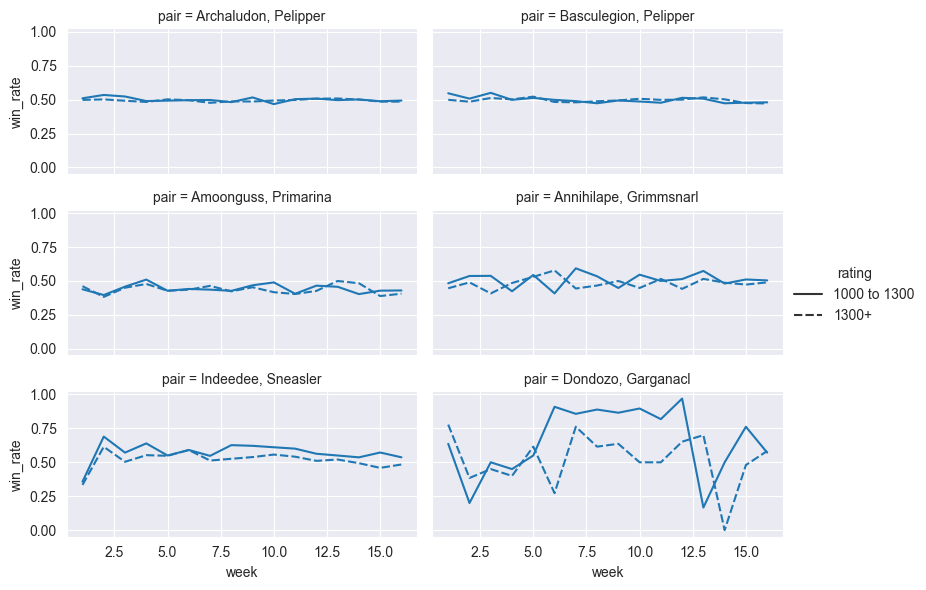

In [16]:
%%time
if 'pair' not in by_ratings_df: by_ratings_df['pair'] = by_ratings_df.apply(lambda row: row.p1 + ", " + row.p2, axis=1)
most_common_pairs = by_ratings_df.groupby(by='pair').agg({"appearances": "sum"}).sort_values(by="appearances", ascending=False)
N = 2
display_list = list(most_common_pairs[:N].index)
APPEARANCES_CUTOFF = 5000
display_list += list(most_common_pairs[most_common_pairs.appearances > APPEARANCES_CUTOFF][-N:].index)
display_list += [
    "Indeedee, Sneasler",
    "Dondozo, Garganacl",
]
display(most_common_pairs.loc[display_list])
facetgrid = sns.relplot(
    data=by_ratings_df[by_ratings_df.pair.isin(display_list)],
    x="week",
    y="win_rate",
    kind="line",
    style="rating",
    col='pair',
    col_wrap=2,
    col_order=display_list,
    aspect=2,
    height=2,
);